In [1]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar, NonlinearConstraint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.linalg import LinAlgError
import pandas as pd
from scipy.stats import norm
from statsmodels.regression.linear_model import OLS
import scipy.stats as stats

In [2]:
#pip install statsmodels

# Define the LS estimator

In [3]:
def d_alpha_fun(alpha):
    if alpha == 0:
        return np.log
    else:
        return lambda x: (x**alpha -1)/alpha

def d_alpha_inv_fun(alpha):
    if alpha == 0:
        return np.exp
    else:
        return lambda x: (x*alpha+1)**(1/alpha)

d_alpha = d_alpha_fun(0)
d_alpha_inv = d_alpha_inv_fun(0)

In [4]:
def convex_matrix(w):
    n = len(w)
    A = np.zeros((n-1, n))

    for i in range(n-1):
        A[i, i] = -1 / (w[i+1] - w[i])
        A[i, i+1] = 1 / (w[i+1] - w[i])

    return A

# Example: create a matrix with a vector w
# w_vector = np.array([1, 2, 4, 7, 11])
# matrix_A =  convex_matrix(w_vector)

# print("Matrix A:")
# print(matrix_A)

def objective_function(vector, y_s, d_alpha_inv):
    return np.sum((y_s - d_alpha_inv(vector))**2)

def constraint(vector, w, d_alpha, epsi):
    return np.concatenate([
        d_alpha(epsi) - vector,
        -d_alpha(1 - epsi) + vector,
        np.dot(convex_matrix(w), vector),
        np.diff(np.dot(convex_matrix(w), vector))
    ])
    
def LS(w, y, d_alpha, d_alpha_inv, epsi):
    w_s, index = np.unique(w, return_index=True)
    n = len(w_s)
    y_s = y[index]

    # w_unique = np.unique(w)
    # n = len(w_unique)
    # w_sorted = np.sort(w_unique)
    # index = np.argsort(w)

    # y_s = [y[i] for i in index]
    # y_s = np.array(y_s, dtype=int)

    # Initial guess for alpha
    vector0 = -np.ones(n)

    # Define the objective and constraints for scipy.optimize
    obj_func = lambda vector: objective_function(vector, y_s, d_alpha_inv)
    nonlinear_constraint = NonlinearConstraint(lambda vector: constraint(vector,w_s, d_alpha, epsi), -np.inf, 0)

    # Minimize the objective function subject to constraints
    result = minimize(obj_func, vector0, constraints=[nonlinear_constraint])

    phi = result.x
    F_hat = interp1d(w_s, 1-d_alpha_inv(phi), kind='linear', fill_value='extrapolate')
    return F_hat

## EXAMPLE: Estimate the CDF of a N(0,1)

In [5]:
epsi= 10**(-12)
n_points = 100
w_example = np.random.uniform(-2, 2, n_points)
y_example = np.where(np.random.normal(0, 1, n_points) > w_example, 1, 0)

result = LS(w_example, y_example, d_alpha, d_alpha_inv, epsi)
F_bar = 1-result(np.sort(w_example))
phi = -1/F_bar

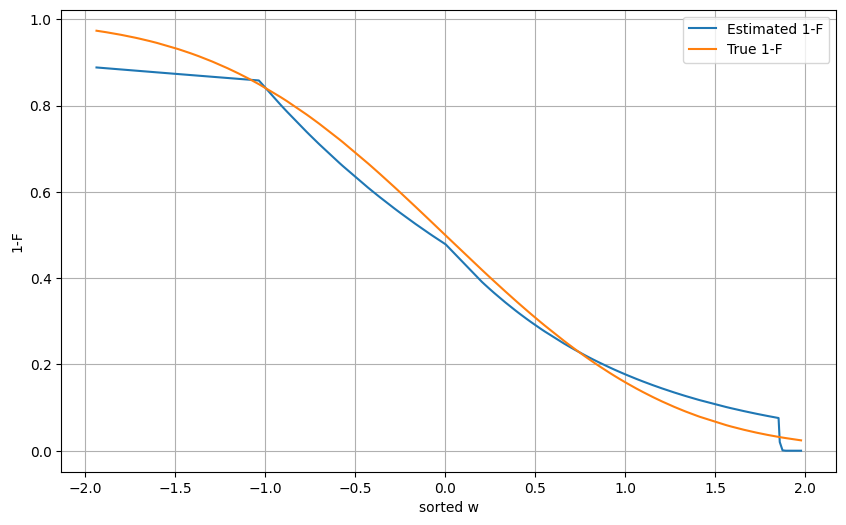

In [6]:
complement_cdf = 1-norm.cdf(np.sort(w_example))

plt.figure(figsize=(10, 6))
plt.plot(np.sort(w_example), F_bar, label='Estimated 1-F')
plt.plot(np.sort(w_example), complement_cdf, label='True 1-F')
plt.xlabel('sorted w')
plt.ylabel('1-F')

plt.legend()
plt.grid(True)
plt.show()

## Simulatin EXAMPLE with the t-student

Here I plot a t-student with $5$ df. We know that for all $\lambda \leq -1/5$, it is $d_{\lambda}$-concave. Here I show that for $\lambda \geq -1/5$ we see non-concavity indeed.

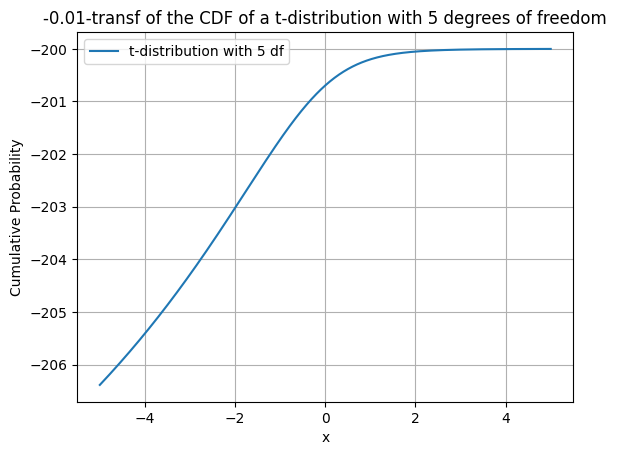

In [32]:
from scipy.stats import t
lamb = -1/100
x = np.linspace(-5, 5, 1000)

# Calculate the cumulative distribution function (CDF) for the t-distribution with 5 degrees of freedom
df = 5
cdf = t.cdf(x, df)

# Plot the CDF of the t-distribution
plt.plot(x, (cdf**lamb+1)/lamb, label='t-distribution with 5 df')
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.title(f'{lamb}-transf of the CDF of a t-distribution with 5 degrees of freedom')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
def LS_example(w, y, d_alpha, d_alpha_inv, epsi):
    w_s, index = np.unique(w, return_index=True)
    n = len(w_s)
    y_s = y[index]

    # Initial guess for alpha
    vector0 = -np.ones(n)

    # Define the objective and constraints for scipy.optimize
    obj_func = lambda vector: objective_function(vector, y_s, d_alpha_inv)
    nonlinear_constraint = NonlinearConstraint(lambda vector: constraint(vector,w_s, d_alpha, epsi), -np.inf, 0)

    # Minimize the objective function subject to constraints
    result = minimize(obj_func, vector0, constraints=[nonlinear_constraint])

    phi = result.x
    F_hat = interp1d(w_s, 1-d_alpha_inv(phi), kind='linear', fill_value='extrapolate')
    obj_value = obj_func(phi)
    
    return F_hat, obj_value
    
epsi= 10**(-12)
df = 5
n_points = 100
w_example = np.random.uniform(-4, 4, n_points)
y_example = np.where(t.rvs(df, size=n_points) > w_example, 1, 0)
seq = [-1/n for n in [2, 3, 4, 5, 10, 20, 50, 100, 200]]
L_2 = []
MSE = []
for lamb in seq:
    d_alpha = d_alpha_fun(lamb)
    d_alpha_inv = d_alpha_inv_fun(lamb)
    
    result, MSE_val = LS_example(w_example, y_example, d_alpha, d_alpha_inv, epsi)
    F_bar = 1-result(np.sort(w_example))
    complement_cdf = 1-t.cdf(np.sort(w_example),df)
    L_2.append(sum(F_bar-complement_cdf)**2)
    MSE.append(MSE_val)

# plt.figure(figsize=(10, 6))
# plt.plot(np.sort(w_example), F_bar, label='Estimated 1-F')
# plt.plot(np.sort(w_example), complement_cdf, label='True 1-F')
# plt.xlabel('sorted w')
# plt.ylabel('1-F')

# plt.legend()
# plt.grid(True)
# plt.show()

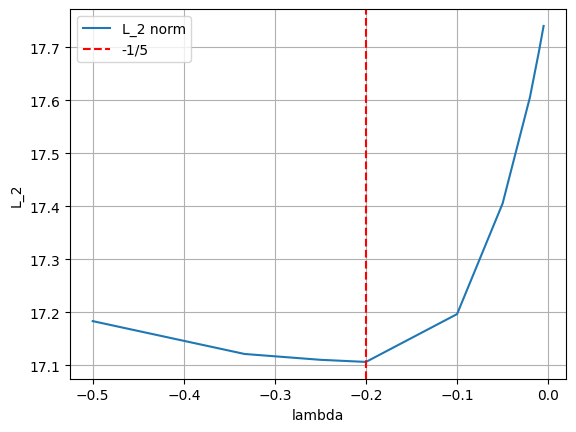

In [54]:
plt.plot(seq, L_2, label='L_2 norm')
plt.axvline(x=-1/5, color='red', linestyle='--', label='-1/5')
plt.xlabel('lambda')
plt.ylabel('L_2')
plt.legend()
plt.grid(True)
plt.show()

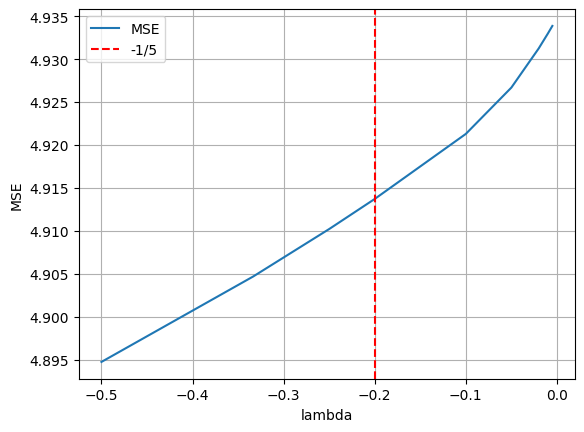

In [57]:
plt.plot(seq, MSE, label='MSE')
plt.axvline(x=-1/5, color='red', linestyle='--', label='-1/5')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# CODE

### Define CDF

#### Twice not third times differentiable

In [10]:
# def cdf_0(x):
#     sign_x = np.sign(x)
#     abs_x = np.abs(x)    
#     term1 = -1/14 * x * (-28 + 3 * abs_x**(4/3) + 3 * abs_x**(4/3) + 3 * ((abs_x)**(1/3) + abs_x**(1/3)) * x * sign_x)
#     term2 = 0.5
#     val = term1 + term2
#     return 0 if x < -0.25 else 1 if x > 0.25 else val

#### N(0,1)

In [11]:
# cdf_0 = stats.norm.cdf #True F_0
# pdf_0 = stats.norm.pdf

#### Laplace

In [12]:
# def cdf_0(x, mu=0, variance=0.8):
#     b = np.sqrt(variance / 2)
#     x = np.array(x)
#     cdf = np.where(
#         x < mu,
#         0.5 * np.exp((x - mu) / b),
#         1 - 0.5 * np.exp(-(x - mu) / b)
#     )
#     return cdf

#### Cauchy

In [27]:
def cdf_0(x, mu=0, gamma= 0.8):
    x = np.array(x)  # Convert x to a numpy array for vectorized operations
    cdf = 1 / np.pi * np.arctan((x -mu)/ gamma) + 0.5
    return cdf

### Define parameters

In [28]:
epsi = 1e-12 # Lower bound of F_0
d = 2 # Dimension of features
H = 6 # Maximum price
tau_0 = 100 # Lenght of the first episode
interc_0 = 3 # True intercept of theta
slope_0 = np.repeat(np.sqrt(2 / 3), d) # True slope of theta
theta_0 = np.concatenate(([interc_0], slope_0))
max_eval = 10 # Maximum number of evaluations (for Confidence Intervals)

### Define Optimal pricing function

In [29]:
from scipy.optimize import minimize

def g_opt(q, F):
    x0 = 0.5 * H  # Adjust the initial guess as needed
    result = minimize(lambda p: -p * (1 - F(p - q)), x0=x0, method='L-BFGS-B', bounds=[(0, H)])
    
    optimal_p = result.x[0]
    return 0 if optimal_p < 0 else H if optimal_p > H else optimal_p

### Distribution of X: support is $[-\sqrt{2/3},\sqrt{2/3}]$

In [30]:
const_x = 128 * np.sqrt(6) / 2835
# def F_x(x):
#     return (-x**7 / 7 + 2 * x**5 / 5 - 4 * x**3 / 9 + 8 * x / 27 + const_x) / (2 * const_x)
    

# range_x = np.linspace(-np.sqrt(2 / 3), np.sqrt(2 / 3), num=10000)
# F_x_val = np.array([F_x(x) for x in range_x])

# # Sample N iid x_t of dimension d. Return design matrix with d+1 columns
# def Sample_x(N, d):
#     u = np.random.uniform(0, 1, d * N)
#     x_sample = np.array([range_x[np.argmin(np.abs(F_x_val - u_j))] for u_j in u])
#     X = x_sample.reshape((N, d))
#     X_tilde = np.column_stack((np.ones(N), X))
#     return X_tilde

def f_x(x):
    return 0 if np.abs(x)>=np.sqrt(2 / 3) else (-x**6 + 2 * x**4 - 4 * x**2/3 + 8/27) / (2 * const_x)
    
def Sample_x(N, d):
    samples = []
    max_x = np.sqrt(2 / 3)  # Range of x
    min_x = -max_x
    c = max([f_x(x) for x in np.linspace(min_x, max_x, 1000)])  # Find the maximum value of f_x

    while len(samples) < N * d:
        # Sample from a uniform distribution (as a proposal distribution)
        x_proposal = np.random.uniform(min_x, max_x)
        u = np.random.uniform(0, c)

        # Acceptance criterion
        if u <= f_x(x_proposal):
            samples.append(x_proposal)

    # Reshape samples into the desired shape and add a column of ones
    X = np.array(samples).reshape(N, d)
    X_tilde = np.column_stack((np.ones(N), X))

    return X_tilde

In [31]:
# # TEST WITH cdf_0 = N(0,1)
# n = 10000
# data = Sample_x(n,3)[:,2]
# plt.hist(data, bins=30, density=True, alpha=0.7, color='blue', label='Histogram')

# # Plot the PDF of a standard normal distribution (N(0, 1))
# x = np.linspace(-1, 1, 1000)
# pdf_values = [f_x(v) for v in x]
# plt.plot(x, pdf_values, 'r-', label='N(0,1) PDF')

# # Add labels and a legend
# plt.xlabel('Value')
# plt.ylabel('Probability Density')
# plt.title('Histogram and N(0,1) PDF Comparison')
# plt.legend()

# # Show the plot
# plt.show()

### Sample from Z: support is $[-0.25,0.25]$

In [32]:
# range_z = np.linspace(-0.25,0.25, num=10000)
# F_z_val = np.array([cdf_0(x) for x in range_z])

# def Sample_z(N):
#     u = np.random.uniform(0, 1, N)
#     z_sample = np.array([range_z[np.argmin(np.abs(F_z_val - u_j))] for u_j in u])
#     return z_sample

def Sample_z(N):
    samples = []
    # Define the range for the uniform proposal distribution
    # Adjust the range and c as necessary for efficiency
    min_x, max_x = -3, 3  # Covering the significant range of the normal distribution
    max_pdf = stats.norm.pdf(0)  # Maximum value of the standard normal PDF

    while len(samples) < N:
        # Sample from the uniform distribution (proposal distribution)
        x_proposal = np.random.uniform(min_x, max_x)
        # Acceptance probability
        acceptance_prob = stats.norm.pdf(x_proposal) / max_pdf

        # Accept or reject the sample
        if np.random.uniform(0, 1) < acceptance_prob:
            samples.append(x_proposal)

    return np.array(samples)


In [33]:
# # TEST WITH cdf_0 = N(0,1)
# n = 10000
# data = Sample_z(n)
# plt.hist(data, bins=30, density=True, alpha=0.7, color='blue', label='Histogram')

# # Plot the PDF of a standard normal distribution (N(0, 1))
# x = np.linspace(-4, 4, 1000)
# pdf_values = norm.pdf(x, loc=0, scale=1)
# plt.plot(x, pdf_values, 'r-', label='N(0,1) PDF')

# # Add labels and a legend
# plt.xlabel('Value')
# plt.ylabel('Probability Density')
# plt.title('Histogram and N(0,1) PDF Comparison')
# plt.legend()

# # Show the plot
# plt.show()

### Kernel functions and Non-Parametric estimation of $F_0$

In [34]:
def kernel(x, m):
    val_2 = (1 - x**2)**3 * (35/12) *np.where(np.abs(x) < 1, 1, 0)
    if m == 2:
        return val_2
    elif m == 4:
        val_4 = (1 - (11/3)*x**2) * val_2 * 27/16
        return val_4
    elif m == 6:
        val_6 = (1 - (26/3)*x**2 + 13*x**4) * val_2 * 297/128
        return val_6

# Kernel derivative function
def kernel_prime(x, m):
    val_2 = (1 - x**2)**3 * (35/12) * np.where(np.abs(x) < 1, 1, 0)
    val_2_prime = - 3*2*x * (1 - x**2)**2 * (35/12) * np.where(np.abs(x) < 1, 1, 0)
    if m == 2:
        return val_2_prime
    elif m == 4:
        val_4_prime = (-27/16) * (11/3) * 2 * x * val_2 + (1 - (11/3)*x**2) * val_2_prime * 27/16
        return val_4_prime
    elif m == 6:
        val_6_prime = (-(26/3)*2*x + 13*4*x**3) * val_2 * (297/128) + (1 - (26/3)*x**2 + 13*x**4) * val_2_prime * 297/128
        return val_6_prime


# Yonki method for NP
def Yonki_NP(w, y, m):
    w_s, index = np.unique(w, return_index=True)
    n = len(w_s)
    y_s = y[index]

    b = 3 * n**(-1/(2*m+1))

    def h(u):
        return np.sum([kernel((w_s[i] - u)/b, m)* y_s[i] for i in range(n)])/ (n*b)

    def h_prime(u):
        return -np.sum([kernel_prime((w_s[i] - u)/b, m)* y_s[i] for i in range(n)])/ (n*(b**2))

    def f(u):
        return np.sum([kernel((w_s[i] - u)/b, m) for i in range(n)])/ (n*b)

    def f_prime(u):
        return -np.sum([kernel_prime((w_s[i] - u)/b, m) for i in range(n)])/ (n*(b**2))

    def F_hat(u):
        return 1 - h(u)/f(u)

    def F_hat_prime(u):
        return -(h_prime(u)*f(u) - h(u)*f_prime(u)) / (f(u)**2)

    #def varphi_hat(u):
    #    return u - (1 - F_hat(u))/F_hat_prime(u)

    F_hat_v = [F_hat(w) for w in w_s]
    F_hat_prime_v = [F_hat_prime(w) for w in w_s]
    #varphi_hat_v = [varphi_hat(w) for w in w_s]
    
    F_hat = interp1d(w_s, F_hat_v, kind='linear', fill_value='extrapolate')
    return F_hat

#### Test Kernel function approach

In [35]:
# x = np.linspace(-1.5, 1.5, 400)

# # Calculate the kernel values for m = 2, 4, 6
# y2 = kernel(x, 2)
# y4 = kernel(x, 4)
# y6 = kernel(x, 6)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(x, y2, label='m = 2')
# plt.plot(x, y4, label='m = 4')
# plt.plot(x, y6, label='m = 6')
# plt.title('Kernel Functions for Different m Values')
# plt.xlabel('x')
# plt.ylabel('Kernel Value')
# plt.legend()
# plt.grid(True)
# plt.show()

#### Test Kernel approach

In [36]:
# n_points = 400
# w_example = np.random.uniform(-3, 3, n_points)
# y_example = np.where(np.random.normal(0, 1, n_points) > w_example, 1, 0)
# result = yonki_np(w_example,y_example,2)

# x = np.linspace(-3, 3, 400)
# F_bar = 1-result(x)
# complement_cdf = 1-norm.cdf(np.sort(x))

# plt.figure(figsize=(10, 6))
# plt.plot(x, F_bar, label='Estimated 1-F')
# plt.plot(x, complement_cdf, label='True 1-F')
# plt.xlabel('sorted w')
# plt.ylabel('1-F')

# plt.legend()
# plt.grid(True)
# plt.show()

### Exploration and Estimation of $\theta_0$ and $F_0$

In [37]:
def exploration_and_estimation(k,m):
    tau_k = tau_0 * 2**(k-1)
    tau_kplus1 = tau_0 * 2**k

    a_k = np.ceil(tau_k**(5/7))
    a_k_Yonki = np.ceil((tau_k * d)**((2*m+1)/(4*m-1)))

    # Exploration phase set
    I_k = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k)
    I_k_Yonki = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k_Yonki)

    # Exploitation phase set
    I_k_prime = np.arange(tau_k - tau_0 + a_k, tau_kplus1 - tau_0)
    I_k_prime_Yonki = np.arange(tau_k - tau_0 + a_k_Yonki, tau_kplus1 - tau_0)

    # Sample from X
    X_tilde = Sample_x(len(I_k), d)
    X_tilde_Yonki = Sample_x(len(I_k_Yonki), d)

    # Sample from X
    Z_t = Sample_z(len(I_k))
    Z_t_Yonki = Sample_z(len(I_k_Yonki))

    # Exploration phase
    c_t = np.random.uniform(0, H, len(I_k))
    c_t_Yonki = np.random.uniform(0, H, len(I_k_Yonki))

    V_t = Z_t + np.dot(X_tilde, theta_0)
    V_t_Yonki = Z_t_Yonki + np.dot(X_tilde_Yonki, theta_0)

    Y_t = V_t > c_t
    Y_t_Yonki = V_t_Yonki > c_t_Yonki

    c_explor_opt = [g_opt(a,cdf_0) for a in np.dot(X_tilde, theta_0)]
    c_explor_opt_Yonki = [g_opt(a,cdf_0) for a in np.dot(X_tilde_Yonki, theta_0)]

    regret_explor = c_explor_opt * (V_t > c_explor_opt).astype(int) - c_t * (V_t > c_t).astype(int)
    regret_explor_Yonki = c_explor_opt_Yonki * (V_t_Yonki > c_explor_opt_Yonki).astype(int) - c_t_Yonki * (V_t_Yonki > c_t_Yonki).astype(int)    
    
    mod = OLS(H * Y_t, X_tilde).fit()
    mod_Yonki = OLS(H * Y_t_Yonki, X_tilde_Yonki).fit()
    
    theta_hat_k = mod.params
    theta_hat_k_Yonki = mod_Yonki.params
    
    W_t = c_t - np.dot(X_tilde, theta_hat_k)
    W_t_Yonki = c_t_Yonki - np.dot(X_tilde_Yonki, theta_hat_k_Yonki)
      
    #print("Computing NPMLE and Yonki")
    F_k = LS(W_t, Y_t, d_alpha, d_alpha_inv, epsi)
    F_k_Yonki = Yonki_NP(W_t_Yonki, Y_t_Yonki,m)

    return {"I_k_prime":I_k_prime, "theta_hat_k":theta_hat_k, "F_k":F_k, "c_explor_opt":c_explor_opt, "regret_explor":regret_explor, "I_k_prime_Yonki":I_k_prime_Yonki, "theta_hat_k_Yonki":theta_hat_k_Yonki, "F_k_Yonki":F_k_Yonki, "c_explor_opt_Yonki":c_explor_opt_Yonki, "regret_explor_Yonki":regret_explor_Yonki}
    

### Exploitation

In [38]:
def exploitation(I_k_prime, theta_hat_k, F_k, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki):
    # NPMLE
    c_hat = []
    W_exploit = []
    Y_exploit = []
    c_exploit_opt = []
    regret_exploit = []

    # Yonki
    c_hat_Yonki = []
    W_exploit_Yonki = []
    Y_exploit_Yonki = []
    c_exploit_opt_Yonki = []
    regret_exploit_Yonki = []
    
    # NMPLE
    for t in I_k_prime:
        x_exploit = Sample_x(1, d)
        g_k = g_opt(x_exploit @ theta_hat_k, F_k)
        c_exploit = np.clip(g_k, 0, H)
        Z_t = Sample_z(1)
        V_t = Z_t + x_exploit @ theta_0
        y_exploit = V_t > c_exploit
        w_exploit = c_exploit - x_exploit @ theta_hat_k
    
        # Optimal true price
        opt_price = g_opt(x_exploit @ theta_0,cdf_0)
        regret_exploit.append(opt_price * (V_t > opt_price) - c_exploit * (V_t > c_exploit))
        c_exploit_opt.append(opt_price)
    
        # Updates
        c_hat.append(c_exploit)
        W_exploit.append(w_exploit)
        Y_exploit.append(y_exploit)
    
    
    # Yonki
    for t in I_k_prime_Yonki:
        x_exploit = Sample_x(1, d)
        g_k_Yonki = g_opt(x_exploit @ theta_hat_k_Yonki, F_k_Yonki)
        c_exploit_Yonki = np.clip(g_k_Yonki, 0, H)
        Z_t = Sample_z(1)
        V_t = Z_t + x_exploit @ theta_0
        y_exploit_Yonki = V_t > c_exploit_Yonki
        w_exploit_Yonki = c_exploit_Yonki - x_exploit @ theta_hat_k_Yonki
    
        # Optimal true price
        opt_price_Yonki = g_opt(x_exploit @ theta_0, cdf_0)
        regret_exploit_Yonki.append(opt_price_Yonki * (V_t > opt_price_Yonki) - c_exploit_Yonki * (V_t > c_exploit_Yonki))
        c_exploit_opt_Yonki.append(opt_price_Yonki)
    
        # Updates
        c_hat_Yonki.append(c_exploit_Yonki)
        W_exploit_Yonki.append(w_exploit_Yonki)
        Y_exploit_Yonki.append(y_exploit_Yonki)

    return {"c_exploit_opt":c_exploit_opt, "regret_exploit":regret_exploit, "c_exploit_opt_Yonki":c_exploit_opt_Yonki, "regret_exploit_Yonki":regret_exploit_Yonki}

### Updates and collect regret

In [39]:
def updates_and_collenct_info(c_exploit_opt, regret_exploit, c_exploit_opt_Yonki, regret_exploit_Yonki, c_explor_opt, regret_explor, c_explor_opt_Yonki, regret_explor_Yonki, Regret, Regret_Yonki):   
  # Updates
  #c_exploit_opt = [float(arr[0]) for arr in c_exploit_opt]
  #c_exploit_opt_Yonki = [float(arr[0]) for arr in c_exploit_opt_Yonki]

  c_opt = np.concatenate((c_explor_opt, c_exploit_opt))
  c_opt_Yonki = np.concatenate((c_explor_opt_Yonki, c_exploit_opt_Yonki))

  # Regret
  regret_exploit = [float(arr[0]) for arr in regret_exploit]
  regret_exploit_Yonki = [float(arr[0]) for arr in regret_exploit_Yonki]

  reg_k = np.concatenate((regret_explor, regret_exploit)).tolist()
  reg_k_Yonki = np.concatenate((regret_explor_Yonki, regret_exploit_Yonki)).tolist()
  
  Regret = np.concatenate((Regret, reg_k))
  Regret_Yonki = np.concatenate((Regret_Yonki, reg_k_Yonki))

  return {"Regret": Regret, "Regret_Yonki": Regret_Yonki}

### Plot the cumulative regret

In [40]:
def plot_results(Regret_eval,Regret_eval_Yonki):
  cumulative_regret = np.cumsum(Regret_eval, axis=0)

  nan_columns = np.any(np.isnan(Regret_eval_Yonki), axis=0)
  Regret_eval_Yonki = Regret_eval_Yonki[:, ~nan_columns]
  cumulative_regret_Yonki = np.cumsum(Regret_eval_Yonki, axis=0)

  horiz_T_NPMLE = cumulative_regret.shape[0]
  horiz_T_Yonki = cumulative_regret_Yonki.shape[0]

  T_NPMLE = np.arange(1, horiz_T_NPMLE + 1)
  T_Yonki = np.arange(1, horiz_T_Yonki + 1)
  # Quantiles for shading along each row
  q_5_NPMLE = np.percentile(cumulative_regret, 5, axis=1)
  q_95_NPMLE = np.percentile(cumulative_regret, 95, axis=1)
  q_5_Yonki = np.percentile(cumulative_regret_Yonki, 5, axis=1)
  q_95_Yonki = np.percentile(cumulative_regret_Yonki, 95, axis=1)

  # Se m=2, crea la finestra con 3 colonne
  if m == 2:
    axs[0].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[0].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[0].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[0].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("regret")
    axs[0].set_title(f"m = {m}")

  # Se m=4, aggiungi un plot al centro e la legenda
  elif m == 4:
    axs[1].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[1].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[1].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[1].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[1].set_xlabel("t")
    #axs[1].set_ylabel("regret")
    axs[1].set_title(f"m = {m}")
    axs[1].legend(["LS", "Kernel"], loc="upper left", frameon=False)

  # Se m=6, aggiungi l'ultimo plot a destra
  elif m == 6:
    axs[2].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[2].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[2].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[2].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[2].set_xlabel("t")
    #axs[2].set_ylabel("regret")
    axs[2].set_title(f"m = {m}")

### MAIN

m =  2
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3
Evaluation 5
Episode 1
Episode 2
Episode 3
Evaluation 6
Episode 1
Episode 2
Episode 3
Evaluation 7
Episode 1
Episode 2
Episode 3
Evaluation 8
Episode 1
Episode 2
Episode 3
Evaluation 9
Episode 1
Episode 2
Episode 3
m =  4
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3
Evaluation 5
Episode 1
Episode 2
Episode 3
Evaluation 6
Episode 1
Episode 2
Episode 3
Evaluation 7
Episode 1
Episode 2
Episode 3
Evaluation 8
Episode 1
Episode 2
Episode 3
Evaluation 9
Episode 1
Episode 2
Episode 3
m =  6
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2


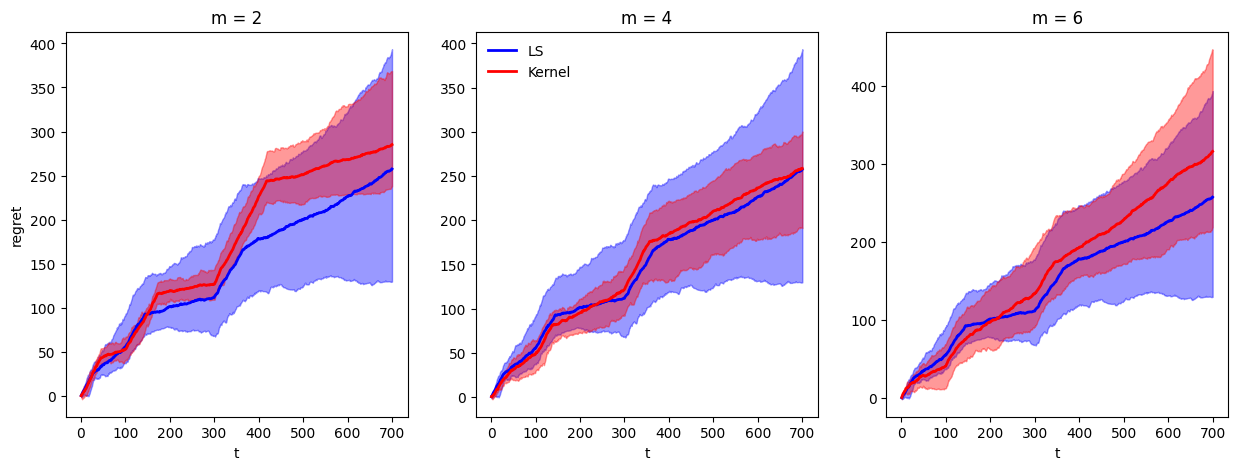

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for m in {2,4,6}:
  print("m = ", m)
  for evalu in range(max_eval):
    print("Evaluation", evalu)
    np.random.seed(evalu+1)
    
    Regret = []
    Regret_Yonki = []
    
    for k in range(1, 4):
      print("Episode", k)
      explor = exploration_and_estimation(k,m)
      
      I_k_prime, theta_hat_k, F_k, c_explor_opt, regret_explor, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki, c_explor_opt_Yonki, regret_explor_Yonki = explor.values()
      exploit = exploitation(I_k_prime, theta_hat_k, F_k, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki)
      
      c_exploit_opt, regret_exploit, c_exploit_opt_Yonki, regret_exploit_Yonki = exploit.values()
      update = updates_and_collenct_info(c_exploit_opt, regret_exploit, c_exploit_opt_Yonki, regret_exploit_Yonki, c_explor_opt, regret_explor, c_explor_opt_Yonki, regret_explor_Yonki, Regret, Regret_Yonki)
      Regret, Regret_Yonki = update.values()
    
    if evalu == 0:
      Regret_eval = np.array(Regret)
      Regret_eval_Yonki = np.array(Regret_Yonki)
    else:
      Regret_eval = np.column_stack((Regret, Regret_eval))
      Regret_eval_Yonki = np.column_stack((Regret_Yonki, Regret_eval_Yonki))

  if m == 2:
      plot_results(Regret_eval,Regret_eval_Yonki)
      same_regret_for_NPLS = Regret_eval
  else:
      plot_results(same_regret_for_NPLS,Regret_eval_Yonki)
    
    
plt.savefig('regret_simulation_cauchy.png')

### Application

In [56]:
#pip install pyreadr

In [26]:
import pyreadr
from statsmodels.formula.api import ols

data_frame = pyreadr.read_r('weeklyRentDemSupply.RData') # also works for Rds
print(data_frame.keys()) 

odict_keys(['weeklyView'])


In [27]:
data = data_frame['weeklyView'].copy()
data = data.dropna()
column_names = data.columns

# Creating data_2 DataFrame
data['MKT_RATE_D_1_5'] = data['MKT_RATE_D'] ** 1.5
data_2 = data[['MKT_RATE_D_1_5', 'SQFT', 'UNIT_TYPE', '12min_MED_HOME_VAL', '20min_MED_HOME_VAL', 'ACT_RATE_D']]
data_2 = pd.get_dummies(data_2, columns=['UNIT_TYPE'], drop_first=True)

X = data_2.drop('ACT_RATE_D', axis=1)
Y = data_2['ACT_RATE_D']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(Y, X).fit()

# Summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             ACT_RATE_D   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                 2.366e+04
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:29:01   Log-Likelihood:            -5.9197e+05
No. Observations:              105864   AIC:                         1.184e+06
Df Residuals:                  105856   BIC:                         1.184e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                140.0163      1

In [28]:
# Residual analysis
res = model.resid
#plt.scatter(range(len(res)), res, c='bl', marker='o', alpha=1, s= 2)
#plt.xlabel('Observation')
#plt.ylabel('Residuals')
#plt.show()

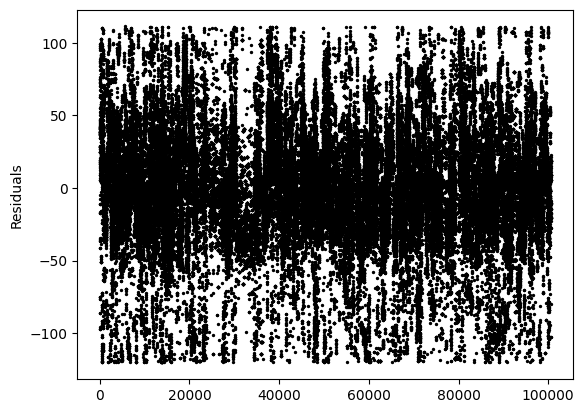

In [29]:
# Quantile analysis
q_025 = np.quantile(res, 0.025)
q_975 = np.quantile(res, 0.975)
delete_index = res[(res >= q_025) & (res <= q_975)].index

res_filtered = res.loc[delete_index]
plt.scatter(range(len(res_filtered)), res_filtered, c='black', marker='o', alpha=1, s= 2)
plt.xlabel('')
plt.ylabel('Residuals')
plt.show()

# Update X and Y based on filtered residuals
X_filtered = X.loc[delete_index]
Y_filtered = Y.loc[delete_index]

# Random sampling
np.random.seed(123)
s = np.random.choice(X_filtered.index, size=len(X_filtered), replace=False)
X_sampled = X_filtered.loc[s]
Y_sampled = Y_filtered.loc[s]


/var/folders/gp/17wdyvd52rz8g_vjf6k01bhc0000gs/T/ipykernel_41255/1113217901.py:20: RuntimeWarning: divide by zero encountered in log
  plt.scatter(Res, np.log(1 - F_0), c='black', alpha=1, s=2)  # Adjust 's' as needed


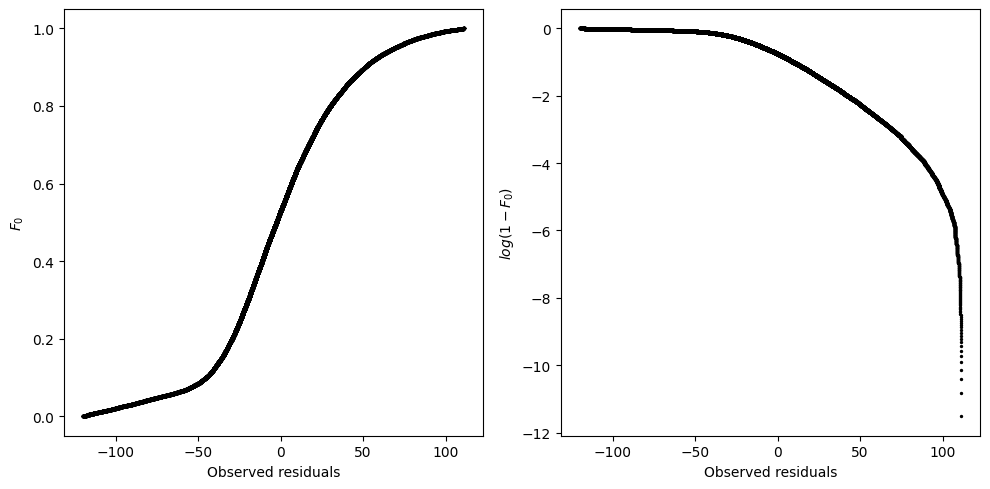

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Sorting the residuals and calculating cumulative frequencies
Res = np.sort(res_filtered)
n = len(Res)
F_0 = np.arange(1, n + 1) / n  # Cumulative frequency

# Plotting
plt.figure(figsize=(10, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.scatter(Res, F_0, c='black', alpha=1, s=2)  # Adjust 's' as needed for dot size
plt.xlabel('Observed residuals')
plt.ylabel('$F_0$')

# Second subplot
plt.subplot(1, 2, 2)
plt.scatter(Res, np.log(1 - F_0), c='black', alpha=1, s=2)  # Adjust 's' as needed
plt.xlabel('Observed residuals')
plt.ylabel('$log(1 - F_0)$')

plt.tight_layout()
plt.show()

# Filtering X and V based on delete_index
X_filtered = X.loc[delete_index]
V_filtered = Y.loc[delete_index]

# Random sampling
np.random.seed(123)
s = np.random.choice(X_filtered.index, size=len(X_filtered), replace=False)
X_sampled = X_filtered.loc[s]
V_sampled = V_filtered.loc[s]

# Alternative approach to remove outliers (commented out)
# remove_index = res[(res < np.quantile(Res, 0.02)) | (res > np.quantile(Res, 0.98))].index
# X_no_outliers = X.drop(remove_index)
# V_no_outliers = Y.drop(remove_index)


In [31]:
type(V_sampled)

pandas.core.series.Series

# Constants

In [32]:
np.max(V_sampled)

1152.3288

In [33]:
epsi = 1e-12 # Lower bound of F_0
d = np.shape(X_sampled)[1]-1
max_V =  np.max(V_sampled)
min_V =  np.min(V_sampled)
V_sampled = V_sampled - min_V
max_V =  np.max(V_sampled)
min_V =  np.min(V_sampled)
tau_0 = 100 # Lenght of the first episode
max_eval = 10

# Optimal price

In [34]:
from scipy.optimize import minimize

def g_opt(q, F):
    x0 = 0.5 * max_V  # Adjust the initial guess as needed
    result = minimize(lambda p: -p * (1 - F(p - q)), x0=x0, method='L-BFGS-B', bounds=[(0, max_V)])
    
    optimal_p = result.x[0]
    return 0 if optimal_p < 0 else max_V if optimal_p > max_V else optimal_p

# Exploration and Estimate

In [35]:
def exploration_and_estimation_application(k,m):
    tau_k = tau_0 * 2**(k-1)  
    tau_kplus1 = tau_0 * 2**k  
    
    a_k = np.ceil(tau_k**(5/7))
    a_k_Yonki = np.ceil((tau_k*d)**((2*m+1)/(4*m-1)))
    
    # Exploration phase set
    I_k = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k).astype(int)
    I_k_Yonki = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k_Yonki).astype(int)
    
    # Exploitation phase set
    I_k_prime = np.arange(tau_k - tau_0 + a_k, tau_kplus1 - tau_0).astype(int)
    I_k_prime_Yonki = np.arange(tau_k - tau_0 + a_k_Yonki, tau_kplus1 - tau_0).astype(int)
    
    # Sample from X
    X_tilde = X_sampled.iloc[I_k,:]
    X_tilde_Yonki = X_sampled.iloc[I_k_Yonki,:]
    
    # Exploration phase
    c_t = np.random.uniform(min_V, max_V, len(I_k))
    c_t_Yonki = np.random.uniform(min_V, max_V, len(I_k_Yonki))
    
    V_t =  V_sampled.iloc[I_k]
    V_t_Yonki = V_sampled.iloc[I_k_Yonki]
    
    Y_t = V_t > c_t
    Y_t_Yonki = V_t_Yonki > c_t_Yonki
    
    regret_explor = c_t * (V_t > c_t).astype(int)
    regret_explor_Yonki = c_t_Yonki * (V_t_Yonki > c_t_Yonki).astype(int)    

    mod = OLS(max_V * Y_t, X_tilde).fit()
    mod_Yonki = OLS(max_V * Y_t_Yonki, X_tilde_Yonki).fit()
    
    theta_hat_k = mod.params
    theta_hat_k_Yonki = mod_Yonki.params
    
    W_t = c_t - np.dot(X_tilde, theta_hat_k)
    W_t_Yonki = c_t_Yonki - np.dot(X_tilde_Yonki, theta_hat_k_Yonki)
    
    #print("Computing NPMLE and Yonki")
    W_t = pd.Series(W_t).reset_index(drop=True)
    Y_t = pd.Series(Y_t).reset_index(drop=True)
    W_t_Yonki = pd.Series(W_t_Yonki).reset_index(drop=True)
    Y_t_Yonki = pd.Series(Y_t_Yonki).reset_index(drop=True)

    F_k = LS(W_t, Y_t, d_alpha, d_alpha_inv, epsi)
    F_k_Yonki = Yonki_NP(W_t_Yonki, Y_t_Yonki,m)
    
    return {"I_k_prime":I_k_prime, "theta_hat_k":theta_hat_k, "F_k":F_k, "regret_explor":regret_explor, "I_k_prime_Yonki":I_k_prime_Yonki, "theta_hat_k_Yonki":theta_hat_k_Yonki, "F_k_Yonki":F_k_Yonki, "regret_explor_Yonki":regret_explor_Yonki}

# Exploitation

In [36]:
def exploitation_application(I_k_prime, theta_hat_k, F_k, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki):
    # NPMLE
    c_hat = []
    W_exploit = []
    Y_exploit = []
    regret_exploit = []
    
    # Yonki
    c_hat_Yonki = []
    W_exploit_Yonki = []
    Y_exploit_Yonki = []
    regret_exploit_Yonki = []
    
    # NMPLE
    for t in I_k_prime:
        x_exploit =  X_sampled.iloc[t,:]
        g_k = g_opt(x_exploit @ theta_hat_k, F_k)
        c_exploit = np.clip(g_k, 0, max_V)
        V_t = V_sampled.iloc[t]
        y_exploit = V_t > c_exploit
        w_exploit = c_exploit - x_exploit @ theta_hat_k
    
        # Optimal true price
        regret_exploit.append(c_exploit * (V_t > c_exploit))
    
        # Updates
        c_hat.append(c_exploit)
        W_exploit.append(w_exploit)
        Y_exploit.append(y_exploit)
    
    
    # Yonki
    for t in I_k_prime_Yonki:
        x_exploit =  X_sampled.iloc[t,:]
        g_k_Yonki = g_opt(x_exploit @ theta_hat_k_Yonki, F_k_Yonki)
        c_exploit_Yonki = np.clip(g_k_Yonki, 0, max_V)
        V_t = V_sampled.iloc[t]
        y_exploit_Yonki = V_t > c_exploit_Yonki
        w_exploit_Yonki = c_exploit_Yonki - x_exploit @ theta_hat_k_Yonki
    
        # Optimal true price
        regret_exploit_Yonki.append(c_exploit_Yonki * (V_t > c_exploit_Yonki))
    
        # Updates
        c_hat_Yonki.append(c_exploit_Yonki)
        W_exploit_Yonki.append(w_exploit_Yonki)
        Y_exploit_Yonki.append(y_exploit_Yonki)
    
    return {"regret_exploit":regret_exploit, "regret_exploit_Yonki":regret_exploit_Yonki}

# Update and collect Regret

In [37]:
def updates_and_collenct_info_application(regret_exploit, regret_exploit_Yonki, regret_explor, regret_explor_Yonki, Regret, Regret_Yonki):
  
  # Regret
  #regret_exploit = [float(arr[0]) for arr in regret_exploit]
  #regret_exploit_Yonki = [float(arr[0]) for arr in regret_exploit_Yonki]
  
  reg_k = np.concatenate((regret_explor, regret_exploit)).tolist()
  reg_k_Yonki = np.concatenate((regret_explor_Yonki, regret_exploit_Yonki)).tolist()
  
  Regret = np.concatenate((Regret, reg_k))
  Regret_Yonki = np.concatenate((Regret_Yonki, reg_k_Yonki))
  
  return {"Regret": Regret, "Regret_Yonki": Regret_Yonki}

# Plot

In [38]:
def plot_results_application(Regret_eval,Regret_eval_Yonki):
  cumulative_regret = np.cumsum(Regret_eval, axis=0)

  nan_columns = np.any(np.isnan(Regret_eval_Yonki), axis=0)
  Regret_eval_Yonki = Regret_eval_Yonki[:, ~nan_columns]
  cumulative_regret_Yonki = np.cumsum(Regret_eval_Yonki, axis=0)

  horiz_T_NPMLE = cumulative_regret.shape[0]
  horiz_T_Yonki = cumulative_regret_Yonki.shape[0]

  T_NPMLE = np.arange(1, horiz_T_NPMLE + 1)
  T_Yonki = np.arange(1, horiz_T_Yonki + 1)
  # Quantiles for shading along each row
  q_5_NPMLE = np.percentile(cumulative_regret, 5, axis=1)
  q_95_NPMLE = np.percentile(cumulative_regret, 95, axis=1)
  q_5_Yonki = np.percentile(cumulative_regret_Yonki, 5, axis=1)
  q_95_Yonki = np.percentile(cumulative_regret_Yonki, 95, axis=1)

  # Se m=2, crea la finestra con 3 colonne
  if m == 2:
    axs[0].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[0].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[0].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[0].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("revenue")
    axs[0].set_title(f"m = {m}")

  # Se m=4, aggiungi un plot al centro e la legenda
  elif m == 4:
    axs[1].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[1].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[1].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[1].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[1].set_xlabel("t")
    #axs[1].set_ylabel("revenue")
    axs[1].set_title(f"m = {m}")
    axs[1].legend(["LS", "Kernel"], loc="upper left", frameon=False)

  # Se m=6, aggiungi l'ultimo plot a destra
  elif m == 6:
    axs[2].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[2].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[2].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[2].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[2].set_xlabel("t")
    #axs[2].set_ylabel("revenue")
    axs[2].set_title(f"m = {m}")

# Main

m =  2
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3
Evaluation 5
Episode 1
Episode 2
Episode 3
Evaluation 6
Episode 1
Episode 2
Episode 3
Evaluation 7
Episode 1
Episode 2
Episode 3
Evaluation 8
Episode 1
Episode 2
Episode 3
Evaluation 9
Episode 1
Episode 2
Episode 3
m =  4
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3
Evaluation 5
Episode 1
Episode 2
Episode 3
Evaluation 6
Episode 1
Episode 2
Episode 3
Evaluation 7
Episode 1
Episode 2
Episode 3
Evaluation 8
Episode 1
Episode 2
Episode 3
Evaluation 9
Episode 1
Episode 2
Episode 3
m =  6
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2


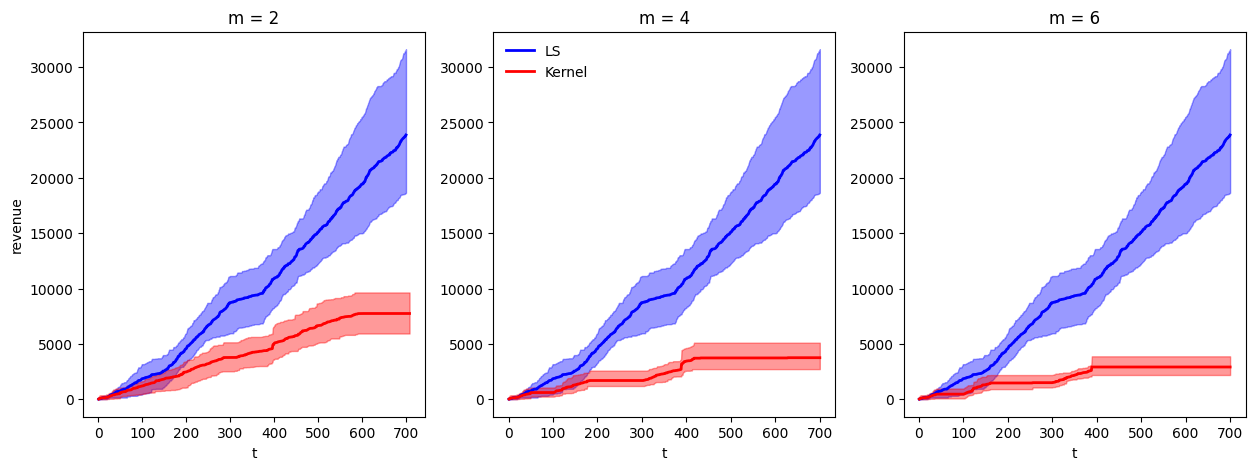

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for m in {2,4,6}:
  print("m = ", m)
  for evalu in range(max_eval):
    print("Evaluation", evalu)
    np.random.seed(evalu+1)
    
    Regret = []
    Regret_Yonki = []
    
    for k in range(1, 4):
      print("Episode", k)
      explore = exploration_and_estimation_application(k,m)
      
      I_k_prime, theta_hat_k, F_k, regret_explor, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki, regret_explor_Yonki = explore.values()
      exploit = exploitation_application(I_k_prime, theta_hat_k, F_k, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki)
      
      regret_exploit, regret_exploit_Yonki = exploit.values()
      update = updates_and_collenct_info_application(regret_exploit, regret_exploit_Yonki, regret_explor, regret_explor_Yonki, Regret, Regret_Yonki)
      Regret, Regret_Yonki = update.values()
    
    if evalu == 0:
      Regret_eval = np.array(Regret)
      Regret_eval_Yonki = np.array(Regret_Yonki)
    else:
      Regret_eval = np.column_stack((Regret, Regret_eval))
      Regret_eval_Yonki = np.column_stack((Regret_Yonki, Regret_eval_Yonki))

  if m == 2:
      plot_results_application(Regret_eval,Regret_eval_Yonki)
      same_regret_for_NPLS = Regret_eval
  else:
      plot_results_application(same_regret_for_NPLS,Regret_eval_Yonki)
    
    
plt.savefig('Revenue_application.png')

In [ ]:
=